In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

# Importing Data Sets

In [56]:
df1 = pd.read_csv("./data/SPX_Real.csv", index_col=False)
df1.columns = ['Timestamp', 'Close']
df1.set_index("Timestamp", inplace=True)
df1.index = pd.to_datetime(df1.index, format='%d-%m-%Y')
df2 = pd.read_csv("./data/AAPL_Real.csv")
df2.columns = ['Timestamp', 'Close']
df2.set_index("Timestamp", inplace=True)
df2.index = pd.to_datetime(df2.index, format='%d-%m-%Y')
df3 = pd.read_csv("./data/TWSE_Real.csv")
df3.columns = ['Timestamp', 'Close']
df3.set_index("Timestamp", inplace=True)
df3.index = pd.to_datetime(df3.index, format='%m/%d/%Y')

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def create_dataset(series, window_size, pred_length):
    X, y = [], []
    for i in range(len(series) - window_size - pred_length + 1):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size : i + window_size + pred_length])
    return np.array(X), np.array(y)



In [ ]:
def get_data_for_period(df, window_size = 20, pred_length = 1):
    val_start = int(len(df) * 0.8)
    test_start = val_start + int(len(df) * 0.1)
    train_data = df.iloc[:val_start]
    val_data   = df.iloc[val_start:test_start]
    test_data  = df.iloc[test_start:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_values = train_data['Close'].values.reshape(-1, 1)
    scaler.fit(train_values)
    
    # Transform the 'Close' column in all splits using the same scaler
    train_scaled = scaler.transform(train_data['Close'].values.reshape(-1, 1)).flatten()
    val_scaled   = scaler.transform(val_data['Close'].values.reshape(-1, 1)).flatten()
    test_scaled  = scaler.transform(test_data['Close'].values.reshape(-1, 1)).flatten()
    
    # Create sliding-window datasets from the scaled data
    X_train, y_train = create_dataset(train_scaled, window_size, pred_length)
    X_val, y_val     = create_dataset(val_scaled, window_size, pred_length)
    X_test, y_test   = create_dataset(test_scaled, window_size, pred_length)
    # Reshape for LSTM: (samples, time_steps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler

In [60]:
dfs = {'SPX': df1, 'AAPL': df2, 'TWSE': df3}

In [61]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', min_value=1, max_value=4, step=1)
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=30, max_value=100, step=10),
                           activation='relu',
                           return_sequences=(num_layers > 1), 
                           input_shape=(X_train.shape[1], 1)))
        else:
            return_seq = (i < num_layers - 1)
            model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=30, max_value=100, step=10),
                           activation='relu',
                           return_sequences=return_seq))
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=pred_length))
    
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mape'])
    return model

def search(X_train, y_train, X_val, y_val, name, pred_length):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=20,
        executions_per_trial=1,
        directory='final_lsttm_tuner_dir',
        project_name=f'stock_forecasting_{name}_pred_length_{pred_length}'
    )

    tuner.search(X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
                
    return tuner

Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_AAPL_pred_length_1/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
794
794


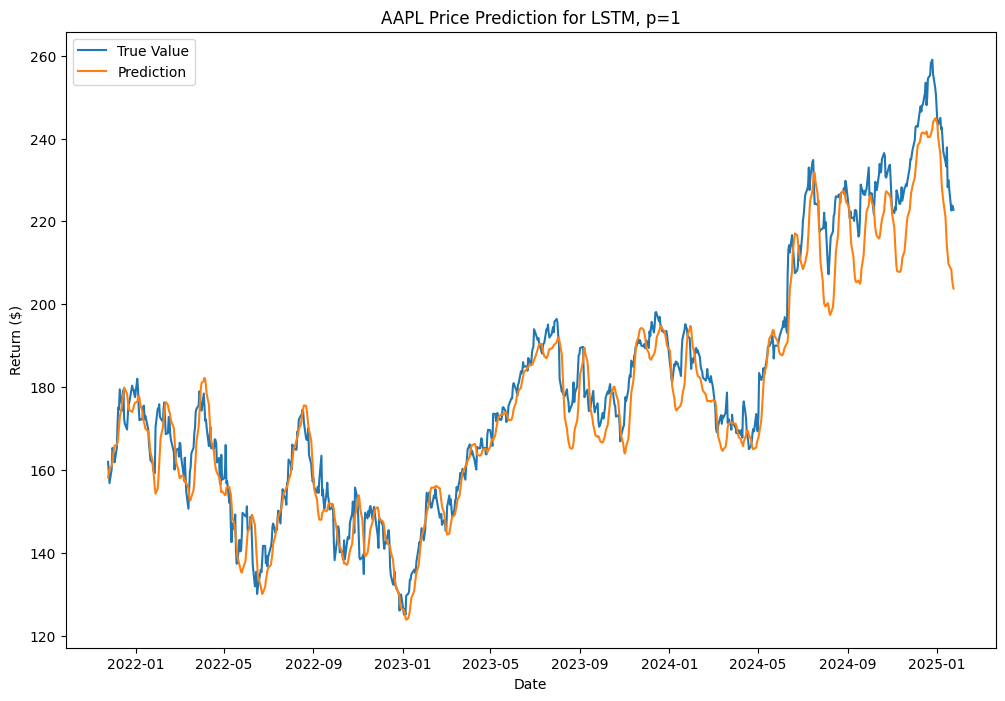

In [85]:
pred_length = 1
(X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = get_data_for_period(dfs['AAPL'], 90, 1)
tuner = search(X_train, y_train, X_val, y_val, 'AAPL', 1)
real_y = scaler.inverse_transform(y_test.reshape(-1, 1))
best_model = tuner.get_best_models(num_models=1)[0]
pred_y = best_model.predict(X_test).flatten().reshape(-1, 1)
adjusted_pred = scaler.inverse_transform(pred_y)
test_dates = dfs['AAPL'].index[-794:]

print(len(test_dates))
print(len(real_y))
plt.figure(figsize=(12,8))
plt.plot(test_dates, real_y[-829:], label='True Value')
plt.plot(test_dates, adjusted_pred[-829:], label='Prediction')
plt.title(f"AAPL Price Prediction for LSTM, p=1")
plt.xlabel('Date')
plt.ylabel('Return ($)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()
plt.close()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

In [79]:
window_size = 115
res = []
for name in dfs:
    for pred_length in [1, 5, 10]:
        (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = get_data_for_period(dfs[name], window_size, pred_length)
        tuner = search(X_train, y_train, X_val, y_val, name, pred_length)

        real_y = scaler.inverse_transform(y_test.reshape(-1, 1))
        best_model = tuner.get_best_models(num_models=1)[0]
        pred_y = best_model.predict(X_test).flatten().reshape(-1, 1)
        adjusted_pred = scaler.inverse_transform(pred_y)

        test_dates = dfs[name].index[-len(y_test):]

        mape = mean_absolute_percentage_error(real_y, adjusted_pred)
        mse = mean_squared_error(real_y, adjusted_pred)
        r2 = r2_score(real_y, adjusted_pred)
        mae = mean_absolute_error(real_y, adjusted_pred)
        print(f"{name} MAPE: {mape:.7f}%")
        print(f"{name} MSE: {mse:.5f}")
        print(f"{name} R2: {r2:.5f}")
        print(f"{name} MAE: {mae:.5f}")

        res.append({
            "DataFrame": name,
            "Prediction_Size": pred_length,
            "MAE": mae,
            "MSE": mse,
            "MAPE": mape,
            "r2": r2
        })
        
        # Plotting
    #     plt.figure(figsize=(12,8))
    #     plt.plot(test_dates, real_y, label='Value')
    #     plt.plot(test_dates, adjusted_pred, label='Prediction')
    #     plt.title(f"Return Prediction for {name}")
    #     plt.xlabel('Date')
    #     plt.ylabel('Return ($)')
    #     handles, labels = plt.gca().get_legend_handles_labels()
    #     by_label = dict(zip(labels, handles))
    #     plt.legend(by_label.values(), by_label.keys())
    # #    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #     plt.show()
    #     plt.close()

results_df = pd.DataFrame(res)
results_df.to_csv("LSTM_errors.csv", index=False)
    


Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_SPX_pred_length_1/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
SPX MAPE: 0.0121978%
SPX MSE: 5136.38265
SPX R2: 0.98892
SPX MAE: 55.57729
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_SPX_pred_length_5/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
SPX MAPE: 0.0263283%
SPX MSE: 24540.19130
SPX R2: 0.94669
SPX MAE: 120.94571
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_SPX_pred_length_10/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
SPX MAPE: 0.0378438%
SPX MSE: 58322.23237
SPX R2: 0.87242
SPX MAE: 178.48428
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_AAPL_pred_length_1/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
AAPL MAPE: 0.0296062%
AAPL MSE: 51.47027
AAPL R2: 0.94217
AAPL MAE: 5.46454
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_AAPL_pred_length_5/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
AAPL MAPE: 0.0437494%
AAPL MSE: 122.47188
AAPL R2: 0.86234
AAPL MAE: 8.13412
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_AAPL_pred_length_10/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
AAPL MAPE: 0.1524321%
AAPL MSE: 1164.01046
AAPL R2: -0.31176
AAPL MAE: 28.91846
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_TWSE_pred_length_1/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
TWSE MAPE: 0.0349191%
TWSE MSE: 1507280.72867
TWSE R2: 0.82422
TWSE MAE: 699.72884
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_TWSE_pred_length_5/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
TWSE MAPE: 0.0271059%
TWSE MSE: 420201.31080
TWSE R2: 0.95079
TWSE MAE: 493.45598
Reloading Tuner from final_lsttm_tuner_dir/stock_forecasting_TWSE_pred_length_10/tuner0.json


/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sunilcotterill/Library/Python/3.10/lib/python/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
TWSE MAPE: 0.0595361%
TWSE MSE: 2833641.22030
TWSE R2: 0.66698
TWSE MAE: 1117.49454
